In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import np_utils
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
#from tensorflow.python.keras.optimizers import Adam, RMSprop
#from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from numpy import loadtxt
import tensorflow.keras
from PIL import Image, ImageOps
%matplotlib inline
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from imutils import paths
%matplotlib inline


In [ ]:
!git clone https://github.com/mohammedtlili/truck_recommandation.git


Cloning into 'truck_recommandation'...
remote: Enumerating objects: 17852, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 17852 (delta 4), reused 8 (delta 0), pack-reused 17834
Receiving objects: 100% (17852/17852), 121.27 MiB | 31.18 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Checking out files: 100% (19175/19175), done.


In [ ]:
# used from keras documentation (flow_from_directory method)

batch_size = 32
image_size = 128

In [ ]:
## Create image generator
# folders with train dir & val dir
train_dir = '/content/truck_recommandation/dataset/train_set'
test_dir = '/content/truck_recommandation/dataset/test_set'
testing_dir = '/content/truck_recommandation/dataset/single_prediction'
input_shape = (image_size, image_size, 3)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, History
import os

In [ ]:
#os.mkdir('model')
os.makedirs('model', exist_ok=True)

In [ ]:
#Model saving based on validation accuracy score
filepath="model/M_categoriel-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [ ]:
# image augmentation technique to enrich our dataset(training set) without adding more images
# so get good performance  results with little or no overfitting even with the small amount of images
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1. / 255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0)



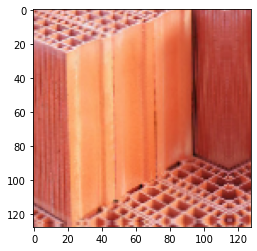

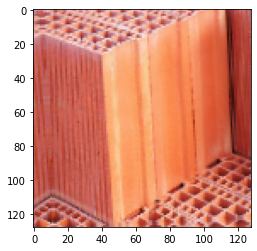

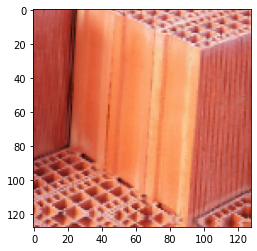

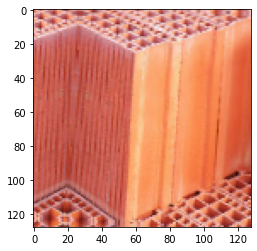

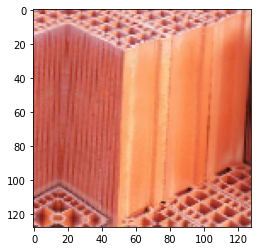

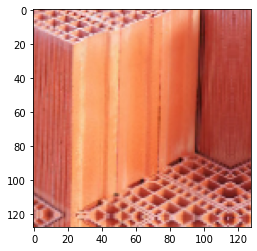

In [ ]:
img_path = '/content/truck_recommandation/dataset/train_set/camionette/Sans-titre-1-17.jpg'
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break
plt.show()

In [ ]:


# create training set
# wanna get higher accuracy -> inccrease target_size
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')





Found 14240 images belonging to 4 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 3560 images belonging to 4 classes.


In [ ]:
testing_datagen = ImageDataGenerator(rescale=1. / 255)

testing_generator = testing_datagen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 0 images belonging to 0 classes.


In [ ]:
train_generator.class_indices

{'camionette': 0, 'fourgon': 1, 'porteur': 2, 'utilitaire': 3}

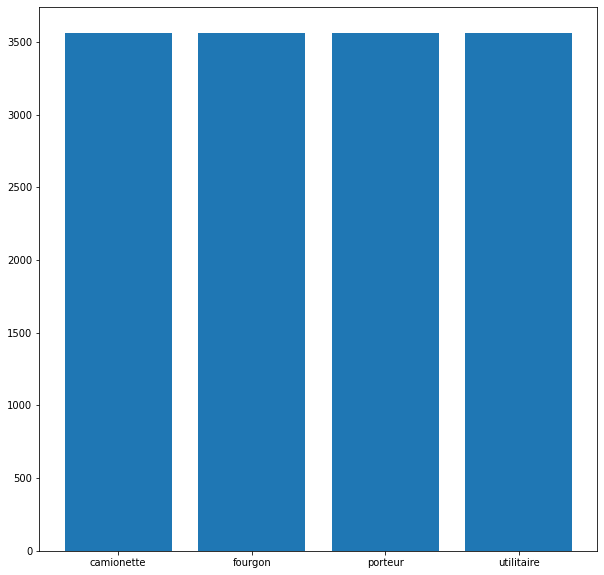

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(4):
    num_values.append(valdict[i])
plt.figure(figsize=(10,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


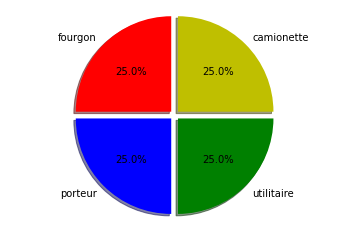

In [ ]:
import matplotlib.pyplot as plt
goal_types = list(train_generator.class_indices.keys())
unique, counts = np.unique(cls_train, return_counts=True)
goals = [(counts)]
colors = ['y','r','b','g']
plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')
plt.show()

['camionette', 'fourgon', 'porteur', 'utilitaire']
[]
OrderedDict([(0, 890), (1, 890), (2, 890), (3, 890)])


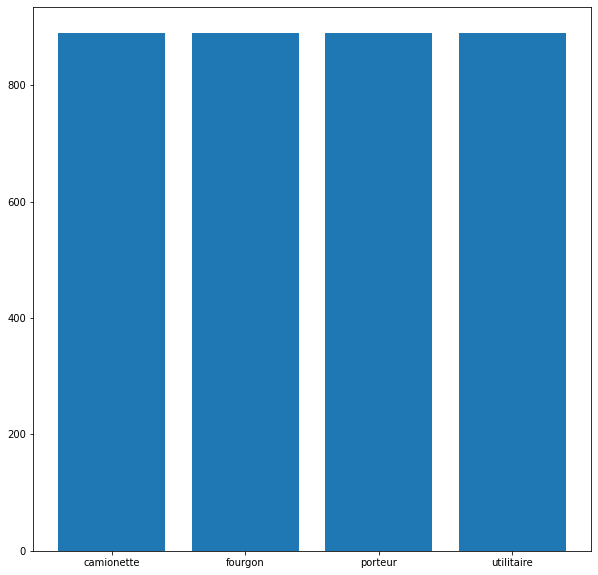

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cls_test = test_generator.classes
from collections import OrderedDict


classes = list(test_generator.class_indices.keys())
print(classes)
num_values = []
print(num_values)

unique, counts = np.unique(cls_test, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
print(valdict)

for i in range(4):
  num_values.append(valdict[i])
plt.figure(figsize=(10,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


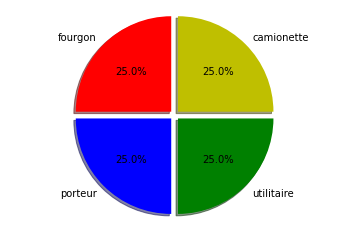

In [ ]:
import matplotlib.pyplot as plt

goal_types = list(test_generator.class_indices.keys())
unique, counts = np.unique(cls_test, return_counts=True)
goals = [(counts)]
colors = ['y','r','b','g']

plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')

plt.show()

In [ ]:
# Download InceptionV3 model
pretrained_model = InceptionV3(weights='imagenet', include_top=False)
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_96 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                    

In [ ]:
pretrained_model.trainable = False
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [ ]:
# Created main layers for end inceptionV3 model
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Activation('relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                         

In [ ]:
# Train a composite neural network based on InceptionV3
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

filepath="inceptionv3_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

steps_per_epoch = 40
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=7,
    verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/7

Epoch 1: val_loss improved from inf to 2.31189, saving model to inceptionv3_best.h5
40/40 - 55s - loss: 1.5398 - accuracy: 0.4148 - val_loss: 2.3119 - val_accuracy: 0.3750 - lr: 0.0010 - 55s/epoch - 1s/step
Epoch 2/7

Epoch 2: val_loss improved from 2.31189 to 1.39234, saving model to inceptionv3_best.h5
40/40 - 47s - loss: 1.1742 - accuracy: 0.5148 - val_loss: 1.3923 - val_accuracy: 0.3812 - lr: 0.0010 - 47s/epoch - 1s/step
Epoch 3/7

Epoch 3: val_loss improved from 1.39234 to 1.20441, saving model to inceptionv3_best.h5
40/40 - 48s - loss: 1.0897 - accuracy: 0.5289 - val_loss: 1.2044 - val_accuracy: 0.4812 - lr: 0.0010 - 48s/epoch - 1s/step
Epoch 4/7

Epoch 4: val_loss did not improve from 1.20441
40/40 - 46s - loss: 1.0526 - accuracy: 0.5695 - val_loss: 1.2497 - val_accuracy: 0.4187 - lr: 0.0010 - 46s/epoch - 1s/step
Epoch 5/7

Epoch 5: val_loss improved from 1.20441 to 1.10107, saving model to inceptionv3_best.h5
40/40 - 48s - loss: 0.9930 - accuracy: 0.5883 - val_loss: 

In [ ]:
test_score = model.evaluate_generator(test_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[INFO] accuracy: 45.21%
[INFO] Loss:  1.1679103374481201


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

  camionette       0.23      0.13      0.17       890
     fourgon       0.26      0.48      0.33       890
     porteur       0.25      0.16      0.20       890
  utilitaire       0.26      0.24      0.25       890

    accuracy                           0.25      3560
   macro avg       0.25      0.25      0.24      3560
weighted avg       0.25      0.25      0.24      3560



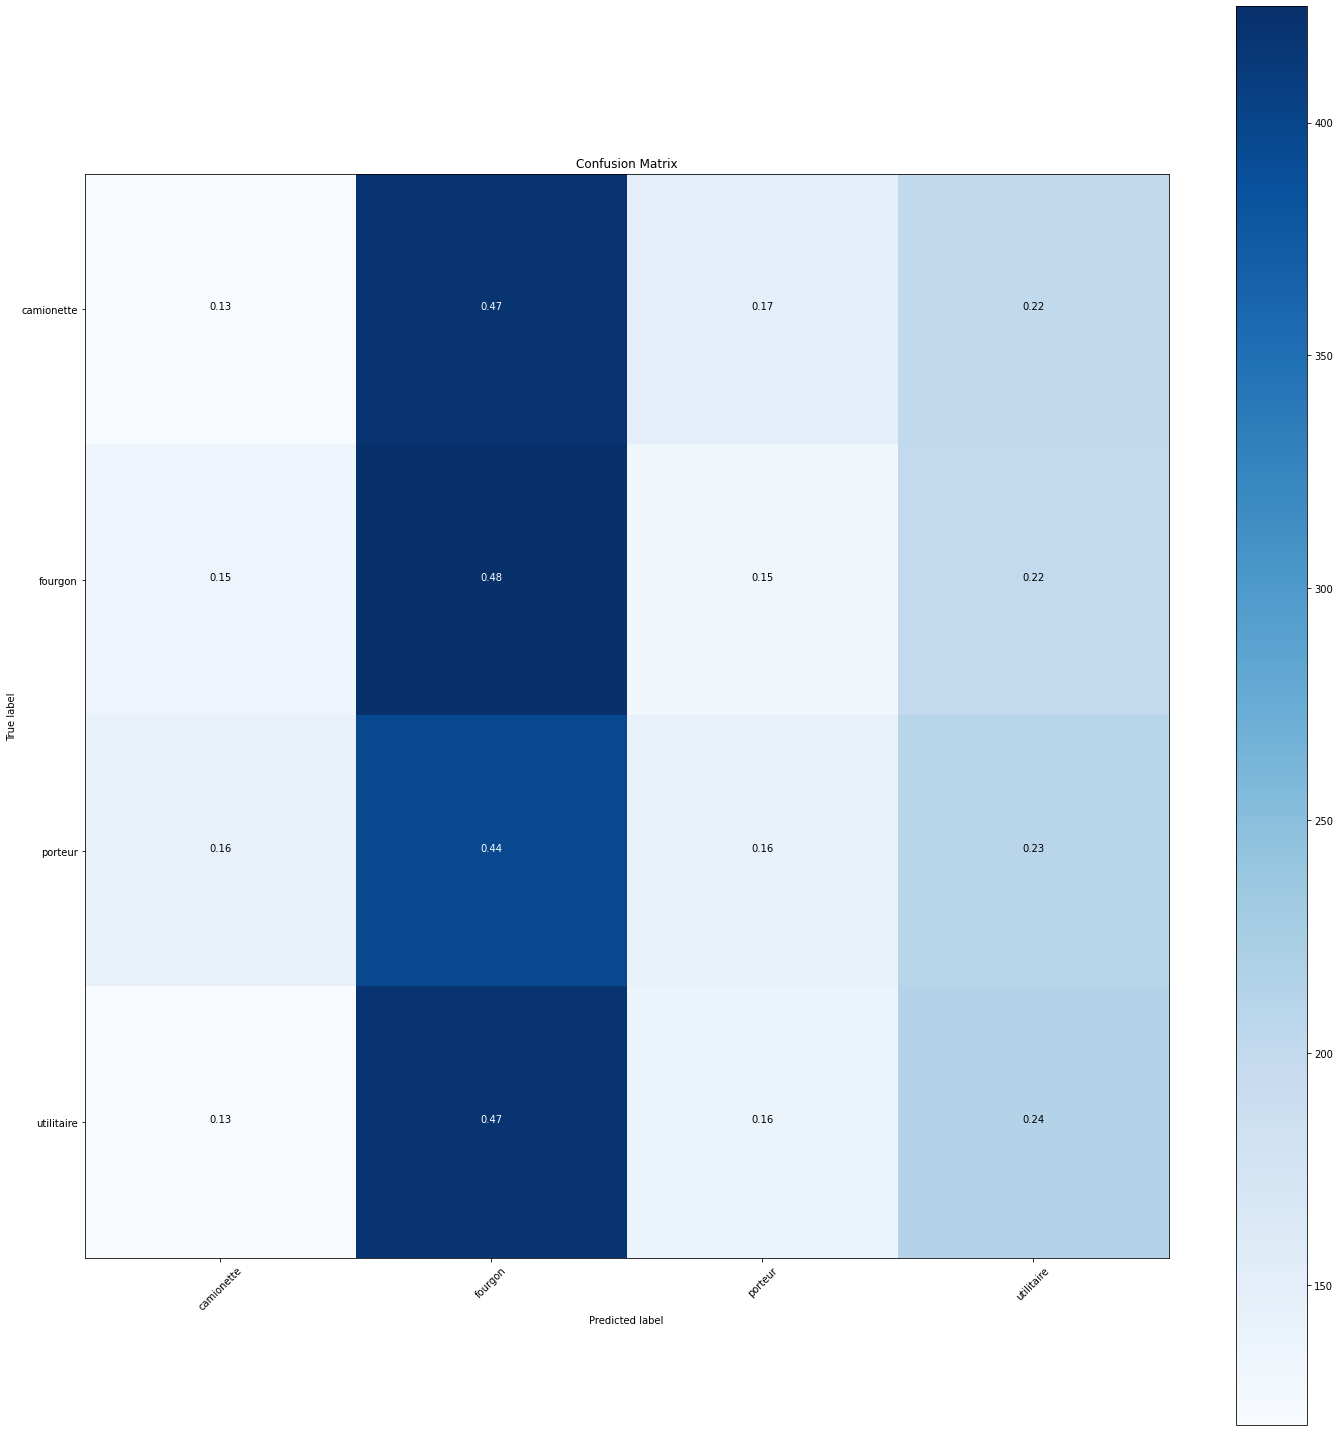

In [ ]:

from matplotlib import cm
import matplotlib.cm as cm
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Text(0.5, 1.0, 'Accuracy Curves')

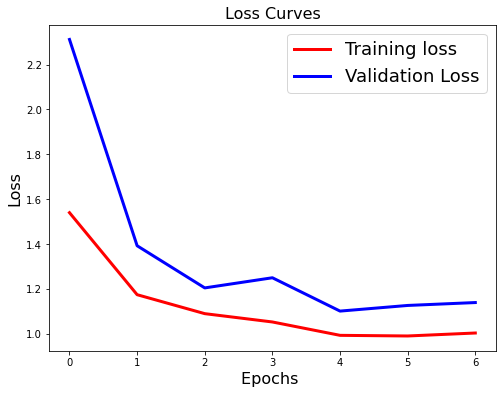

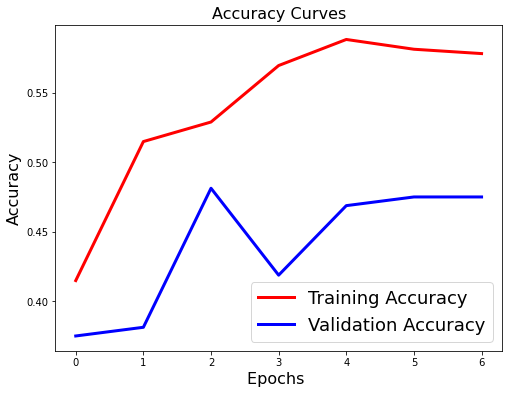

In [ ]:
##Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

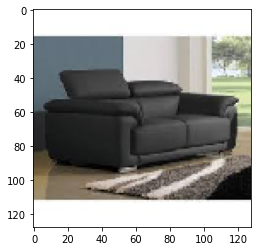

In [ ]:
img_path = '/content/truck_recommandation/dataset/single_prediction/images (2).jpg'

img = image.load_img(img_path, target_size=(128, 128))
plt.imshow(img)
plt.show()

In [ ]:
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

In [ ]:
prediction = model.predict(x)

In [ ]:
prediction

array([[0.05131766, 0.5456936 , 0.02296335, 0.38002545]], dtype=float32)

In [ ]:
classes = np.argmax(prediction, axis = 1)
print(classes)

[1]
